# Chapter 25

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [2]:
# import functions from modsim

from modsim import *

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master//chapters/chap25.ipynb)

In the previous chapter we modeled a system with constant angular
velocity.
In this chapter we take the next step, modeling a system with angular acceleration and deceleration.

## Angular acceleration

Just as linear acceleration is the derivative of velocity, **angular
acceleration** is the derivative of angular velocity. And just as linear acceleration is caused by force, angular acceleration is caused by the rotational version of force, **torque**. If you are not familiar with torque, you can read about it at <http://modsimpy.com/torque>.

In general, torque is a vector quantity, defined as the **cross
product** of $\vec{r}$ and $\vec{F}$, where $\vec{r}$ is the **lever
arm**, a vector from the center of rotation to the point where the force is applied, and $\vec{F}$ is the vector that represents the magnitude and direction of the force.

However, for the problems in this chapter, we only need the *magnitude* of torque; we don't care about the direction. In that case, we can compute 

$$\tau = r F \sin \theta$$ 

where $\tau$ is torque, $r$ is the length of the lever arm, $F$ is the magnitude of force, and $\theta$ is the angle between $\vec{r}$ and $\vec{F}$.

Since torque is the product of a length and a force, it is expressed in newton meters (Nm).

## Moment of inertia

In the same way that linear acceleration is related to force by Newton's second law of motion, $F=ma$, angular acceleration is related to torque by another form of Newton's law: 

$$\tau = I \alpha$$ 

where $\alpha$ is angular acceleration and $I$ is **moment of inertia**. Just as mass is what makes it hard to accelerate an object, moment of inertia is what makes it hard to spin an object.

In the most general case, a 3-D object rotating around an arbitrary
axis, moment of inertia is a tensor, which is a function that takes a
vector as a parameter and returns a vector as a result.

Fortunately, in a system where all rotation and torque happens around a single axis, we don't have to deal with the most general case. We can treat moment of inertia as a scalar quantity.

For a small object with mass $m$, rotating around a point at distance
$r$, the moment of inertia is $I = m r^2$. For more complex objects, we can compute $I$ by dividing the object into small masses, computing
moments of inertia for each mass, and adding them up.

However, for most simple shapes, people have already done the
calculations; you can just look up the answers. For example, see
<http://modsimpy.com/moment>.

## Teapots and turntables

Tables in Chinese restaurants often have a rotating tray or turntable
that makes it easy for customers to share dishes. These turntables are
supported by low-friction bearings that allow them to turn easily and
glide. However, they can be heavy, especially when they are loaded with food, so they have a high moment of inertia.

Suppose I am sitting at a table with a pot of tea on the turntable
directly in front of me, and the person sitting directly opposite asks
me to pass the tea. I push on the edge of the turntable with 2 N of
force until it has turned 0.5 rad, then let go. The turntable glides
until it comes to a stop 1.5 rad from the starting position. How much
force should I apply for a second push so the teapot glides to a stop
directly opposite me?

We'll answer this question in these steps:

1.  I'll use the results from the first push to estimate the coefficient of friction for the turntable.

2.  As an exercise, you'll use that coefficient of friction to estimate the force needed to rotate the turntable through the remaining angle.

Our simulation will use the following parameters:

1.  The radius of the turntable is 0.5 m, and its weight is 7 kg.

2.  The teapot weights 0.3 kg, and it sits 0.4 m from the center of the turntable.

The following figure shows the scenario, where $F$ is the force I apply to the turntable at the perimeter, perpendicular to the lever arm, $r$, and $\tau$ is the resulting torque. The blue circle near the bottom is the teapot.

![Diagram of a turntable with a
teapot.](https://github.com/AllenDowney/ModSim/raw/main/figs/teapot.png)

Here are the parameters from the statement of the problem:

In [3]:
from numpy import pi

radius_disk = 0.5     # m
mass_disk = 7         # kg
radius_pot = 0.4      # m
mass_pot = 0.3        # kg
force = 2             # N

theta_push = 0.5        # radian
theta_test = 1.5        # radian
theta_target = pi       # radian

`theta_push` is the angle where I stop pushing on the turntable.
`theta_test` is how far the table turns during my test push.
`theta_target` is where we want the table to be after the second push.

We can use these parameters to compute the moment of inertia of the turntable, using the formula for a horizontal disk revolving around a vertical axis through its center: 

In [4]:
I_disk = mass_disk * radius_disk**2 / 2

We can also compute the moment of inertia of the teapot, treating it as a point mass:

In [5]:
I_pot = mass_pot * radius_pot**2

The total moment of inertia is the sum of these parts:

In [6]:
I_total = I_disk + I_pot

Friction in the bearings probably depends on the weight of the turntable and its contents, but probably does not depend on angular velocity.
So we'll assume that it is a constant.
We don't know what it is, so I will start with a guess, and we will use `root_scalar` to improve it.

In [7]:
torque_friction = 0.3   # N*m

For this problem we'll treat friction as a torque.

The state variables we'll use are `theta`, which is the angle of the table in rad, and `omega`, which is angular velocity in rad/s.

In [8]:
init = State(theta=0, omega=0)

Now we can make a `System` with the initial state, `init`, the maximum duration of the simulation, `t_end`, and the parameters we are going to vary, `force` and `torque_friction`.

In [9]:
system = System(init=init, 
                force=force,
                torque_friction=torque_friction,
                t_end=20)

Here's a slope function that takes the current state, which contains angle and angular velocity, and returns the derivatives, angular velocity and angular acceleration:

In [10]:
def slope_func(t, state, system):
    theta, omega = state
    force = system.force
    torque_friction = system.torque_friction
    
    torque = radius_disk * force - torque_friction
    alpha = torque / I_total
    
    return omega, alpha 

In this scenario, the force I apply to the turntable is always
perpendicular to the lever arm, so $\sin \theta = 1$ and the torque due
to force is $\tau = r F$.

`torque_friction` represents the torque due to friction. Because the
turntable is rotating in the direction of positive `theta`, friction
acts in the direction of negative `theta`.

We can test the slope function with the initial conditions:

In [11]:
slope_func(0, system.init, system)

(0, 0.7583965330444203)

We are almost ready to run the simulation, but first there's a problem we have to address.

## Two Phase Simulation

When I stop pushing on the turntable, the angular acceleration changes
abruptly. We could implement the slope function with an `if` statement
that checks the value of `theta` and sets `force` accordingly. And for a coarse model like this one, that might be fine. But a more robust approach is to simulate the system in two phases:

1.  During the first phase, force is constant, and we run until `theta` is 0.5 radians.

2.  During the second phase, force is 0, and we run until `omega` is 0.

Then we can combine the results of the two phases into a single
`TimeFrame`.

Here's the event function I'll use for Phase 1; it stops the simulation when `theta` reaches `theta_push`, which is when I stop pushing:

In [12]:
def event_func1(t, state, system):
    theta, omega = state
    return theta - theta_push

We can test it with the initial conditions.

In [13]:
event_func1(0, system.init, system)

-0.5

And run the first phase of the simulation.

In [14]:
results1, details1 = run_solve_ivp(system, slope_func,
                                   events=event_func1)
details1.message

'A termination event occurred.'

Here are the last few time steps.

In [15]:
results1.tail()

,theta,omega
1.102359,0.46080,0.836025
1.113842,0.47045,0.844734
1.125325,0.48020,0.853442
1.136808,0.49005,0.862151
1.148291,0.50000,0.870860


It takes a little more than a second for me to rotate the table 0.5 rad.
When I release the table, the angular velocity is about 0.87 rad / s.

Before we run the second phase, we have to extract the final time and
state of the first phase.

In [16]:
t_2 = results1.index[-1]
init2 = results1.iloc[-1]

Now we can make a `System` object for Phase 2 with the initial state
from Phase 1 and with `force=0`.

In [17]:
system2 = system.set(t_0=t_2, init=init2, force=0)

For the second phase, we need an event function that stops when the
turntable stops; that is, when angular velocity is 0.

In [18]:
def event_func2(t, state, system):
    theta, omega = state
    return omega

We'll test it with the initial conditions for Phase 2.

In [19]:
event_func2(system2.t_0, system2.init, system2)

0.8708596517490182

Now we can run the second phase.

In [20]:
results2, details2 = run_solve_ivp(system2, slope_func,
                                   events=event_func2)
details2.message

'A termination event occurred.'

`DataFrame` provides `append`, which appends `results2` to the end of
`results1`.

In [21]:
results = results1.append(results2)

Here are the last few time steps.

In [22]:
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-2.220446e-16


At the end, angular velocity is close to 0, and the total rotation is about 1.7 rad, a little farther than we were aiming for.

We can plot `theta` for both phases.

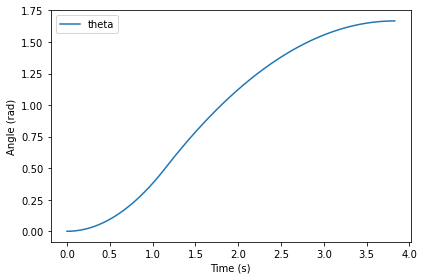

In [23]:
results.theta.plot(label='theta')
decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')

And `omega`.

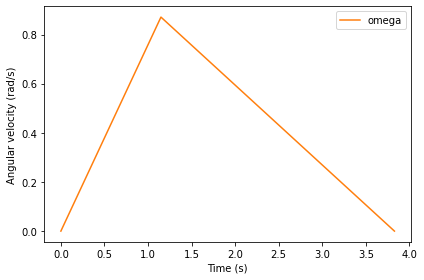

In [24]:
results.omega.plot(label='omega', color='C1')
decorate(xlabel='Time (s)',
             ylabel='Angular velocity (rad/s)')

Angular velocity, `omega`, increases linearly while I am pushing, and decreases linearly after I let go. The angle, `theta`, is the integral of angular velocity, so it forms a parabola during each phase.

In the next section, we'll use this simulation to estimate the torque
due to friction.

## Estimating Friction

Let's take the code from the previous section and wrap it in a function.

In [25]:
def run_two_phases(force, torque_friction, system):
    
    # put the specified parameters into the System object
    system1 = system.set(force=force, 
                         torque_friction=torque_friction)

    # run phase 1
    results1, details1 = run_solve_ivp(system1, slope_func, 
                                       events=event_func1)

    # get the final state from phase 1
    t_2 = results1.index[-1]
    init2 = results1.iloc[-1]
    
    # run phase 2
    system2 = system1.set(t_0=t_2, init=init2, force=0)
    results2, details2 = run_solve_ivp(system2, slope_func, 
                                       events=event_func2)
    
    # combine and return the results
    results = results1.append(results2)
    return results

I'll test it with the same parameters.

In [26]:
force = 2
torque_friction = 0.3
results = run_two_phases(force, torque_friction, system)
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-2.220446e-16


These results are the same as in the previous section.

We can use `run_two_phases` to write an error function we can use, with `root_scalar`, to find the torque due to friction that yields the
observed results from the first push, a total rotation of 1.5 rad.

In [27]:
def error_func1(torque_friction, system):
    force = system.force
    results = run_two_phases(force, torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(torque_friction, theta_final)
    return theta_final - theta_test

With `torque_friction=0.3`, the table rotates a bit too far:

In [28]:
guess1 = 0.3
error_func1(guess1, system)

0.3 1.666666666666669


0.16666666666666896

With `torque_friction=0.4`, it doesn't go far enough.

In [29]:
guess2 = 0.4
error_func1(guess2, system)

0.4 1.2499999999999996


-0.25000000000000044

So we can use those two values as a bracket for `root_scalar`.

In [30]:
res = root_scalar(error_func1, system, bracket=[guess1, guess2])

0.3 1.666666666666669
0.3 1.666666666666669
0.4 1.2499999999999996
0.3400000000000003 1.4705882352941169
0.3340000000000002 1.4970059880239517
0.3333320000000001 1.5000060000239976
0.3333486666010001 1.4999310034693254


The result is 0.333 N m, a little less than the initial guess.

In [31]:
actual_friction = res.root
actual_friction

0.3333320000000001

Now that we know the torque due to friction, we can compute the force
needed to rotate the turntable through the remaining angle, that is,
from 1.5 rad to 3.14 rad.

But first, let's animate the results.

## Animation


Here's a function that takes the state of the system and draws it.

In [32]:
from matplotlib.patches import Circle
from matplotlib.pyplot import gca, axis

def draw_func(t, state):
    theta, omega = state
    
    # draw a circle for the table
    circle1 = Circle([0, 0], radius_disk)
    gca().add_patch(circle1)
    
    # draw a circle for the teapot
    center = pol2cart(theta, radius_pot)
    circle2 = Circle(center, 0.05, color='C1')
    gca().add_patch(circle2)

    axis('equal')

This function uses a few features we have not seen before, but you can read about them in the Matplotlib documentation.

Here's what the initial condition looks like.

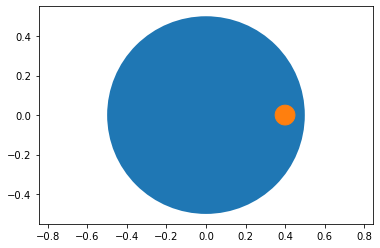

In [33]:
state = results.iloc[0]
draw_func(0, state)

And here's an animation of the first push.

In [34]:
# animate(results, draw_func)

## Summary

The example in this chapter demonstrates the concepts of torque, angular acceleration, and moment of inertia.
We used these concepts to simulate a turntable, using a hypothetical observation to estimating torque due to friction.
As an exercise, you can finish off the example, estimating the force needed to rotate the table to a given target angle.

The next chapter describes several case studies you can work on to practice the tools from the last few chapters, including projectiles, rotating objects, `root_scalar`, and `maximize_scalar`.

## Exercises

**Exercise:** Continuing the example from this chapter, estimate the force that delivers the teapot to the desired position.
Use this `System` object, with the friction we computed in the previous section.

In [35]:
system3 = system.set(torque_friction=actual_friction)

Write an error function that takes `force` and `system`, simulates the system, and returns the difference between `theta_final` and the remaining angle after the first push.

In [36]:
remaining_angle = theta_target - theta_test
remaining_angle

1.6415926535897931

Use your error function and `root_scalar` to find the force needed for the second push.
Run the simulation with the force you computed and confirm that the table stops at the target angle after both pushes.

In [37]:
# Solution

def error_func2(force, system):
    """Error function for root_scalar.
    
    force: hypothetical value
    
    returns: offset from target value
    """
    results = run_two_phases(force, system.torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(force, theta_final)
    return theta_final - remaining_angle

In [38]:
# Solution

guess1 = 2.0
error_func2(guess1, system3)

2.0 1.5000060000239976


-0.14158665356579547

In [39]:
# Solution

guess2 = 3.0
error_func2(guess2, system3)

3.0 2.250009000035999


0.608416346446206

In [40]:
# Solution

res = root_scalar(error_func2, system3, bracket=[guess1, guess2])

2.0 1.5000060000239976
2.0 1.5000060000239976
3.0 2.250009000035999
2.1887814496255746 1.641592653589789
2.188890888699056 1.6416747332232227


In [41]:
# Solution

force = res.root
results = run_two_phases(force, actual_friction, system3)
theta_final = results.iloc[-1].theta
theta_final + theta_test

3.1415926535897887

In [42]:
# Solution

theta_target

3.141592653589793